In [1]:
import tensorflow as tf 

from IPython.display import display 
from PIL import Image

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os

#print(os.listdir("train"))

Using TensorFlow backend.


In [3]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


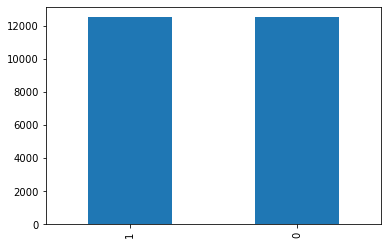

In [4]:
df['category'].value_counts().plot.bar()

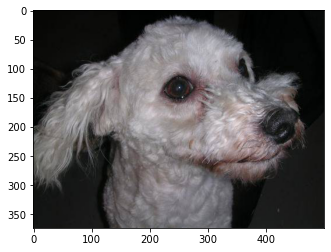

In [5]:
sample = random.choice(filenames)
image = load_img("train/"+sample)
plt.imshow(image)

In [6]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 4
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False
    

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
tot=len(df)

categories_name=[]

for cate in range(tot):
    
    if df["category"][cate] == 1:
        categories_name.append('dog')
    else:
        categories_name.append('cat')
        
df["categories_name"]=categories_name

print(df)

           filename  category categories_name
0         cat.0.jpg         0             cat
1         cat.1.jpg         0             cat
2        cat.10.jpg         0             cat
3       cat.100.jpg         0             cat
4      cat.1000.jpg         0             cat
...             ...       ...             ...
24995  dog.9995.jpg         1             dog
24996  dog.9996.jpg         1             dog
24997  dog.9997.jpg         1             dog
24998  dog.9998.jpg         1             dog
24999  dog.9999.jpg         1             dog

[25000 rows x 3 columns]


In [9]:
train_df, validate_df = train_test_split(df, test_size=0.1)

#print(train_df.head(),"\n",validate_df.head(),"\n________________\n")

train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

#print(train_df.head(),"\n",validate_df.head())

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [10]:
#The ImageDataGenerator is an easy way to load and augment images in batches for image classification tasks
#https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c


In [11]:
#data augmentation

batch_size=32

train_datagen = ImageDataGenerator(                   
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train", 
    x_col='filename',
    y_col='categories_name',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=32
)

Found 22500 validated image filenames belonging to 2 classes.


In [12]:
#Validation Generator



validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train", 
    x_col='filename',
    y_col='categories_name',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=32
)

Found 2500 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


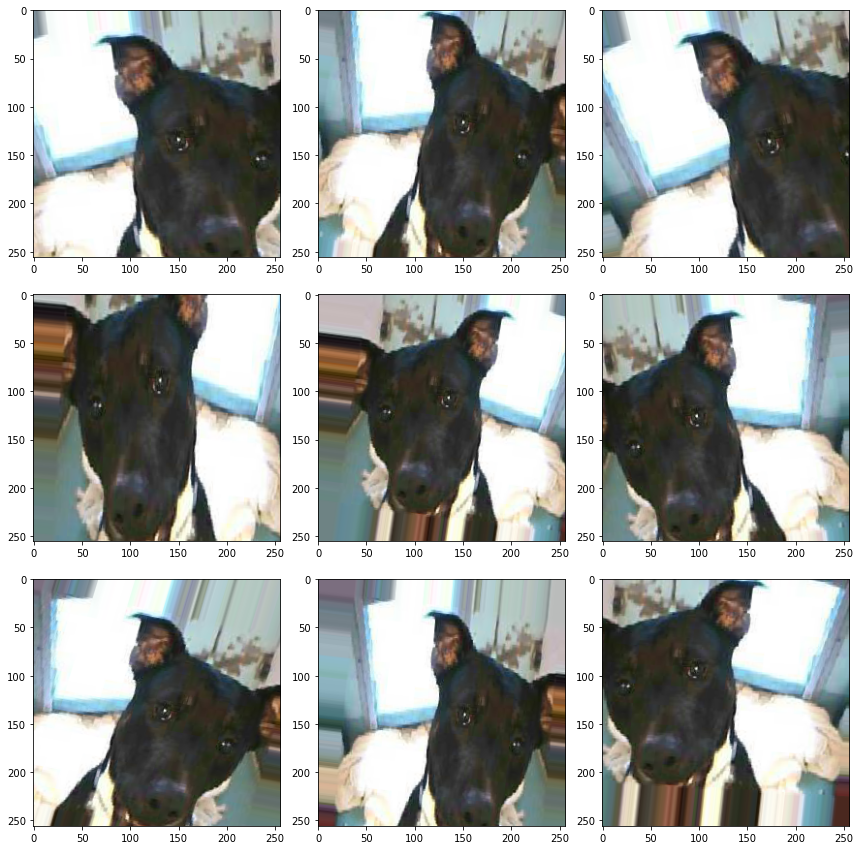

In [13]:
#See sample generated images


pd.value_counts(df["categories_name"])


example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train", 
    x_col='filename',
    y_col='categories_name',                               #Here i used categorical because binary requires two classes 
    class_mode='categorical'
)

plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11190230966217257557
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3135687884
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1946991822776359231
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [15]:
#Fit Model

# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/4
703/703 [==============================] - 2750s 4s/step - loss: 0.3871 - accuracy: 0.8112 - val_loss: 0.2185 - val_accuracy: 0.9267
Epoch 2/4
703/703 [==============================] - 495s 703ms/step - loss: 0.1897 - accuracy: 0.9218 - val_loss: 0.1944 - val_accuracy: 0.9404
Epoch 3/4
703/703 [==============================] - 358s 510ms/step - loss: 0.1539 - accuracy: 0.9367 - val_loss: 0.0471 - val_accuracy: 0.9489
Epoch 4/4
703/703 [==============================] - 326s 463ms/step - loss: 0.1364 - accuracy: 0.9446 - val_loss: 0.0744 - val_accuracy: 0.9449


In [16]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))


Test: accuracy = 0.945913  ;  loss = 0.226884 


In [19]:
# def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
#     fig, axs = plt.subplots(1,2,figsize=(15,5))
#     axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
#     axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
#     axs[0].set_title('Model Accuracy')
#     axs[0].set_ylabel('Accuracy')
#     axs[0].set_xlabel('Epoch')
#     axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
#     axs[0].legend(['train', 'val'], loc='best')
#     axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
#     axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
#     axs[1].set_title('Model Loss')
#     axs[1].set_ylabel('Loss')
#     axs[1].set_xlabel('Epoch')
#     axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
#     axs[1].legend(['train', 'val'], loc='best')
#     plt.show()
    
# plot_model_history(history)

In [20]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [21]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [22]:
y_final.size

2500

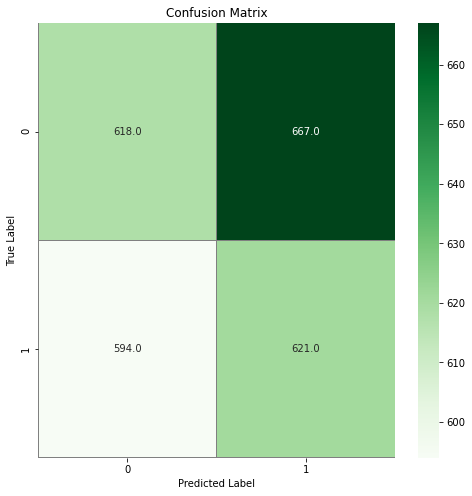

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [25]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.51      0.48      0.49      1285
           1       0.48      0.51      0.50      1215

    accuracy                           0.50      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       0.50      0.50      0.50      2500



In [27]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [29]:
#Create Testing Generator

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


In [30]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)





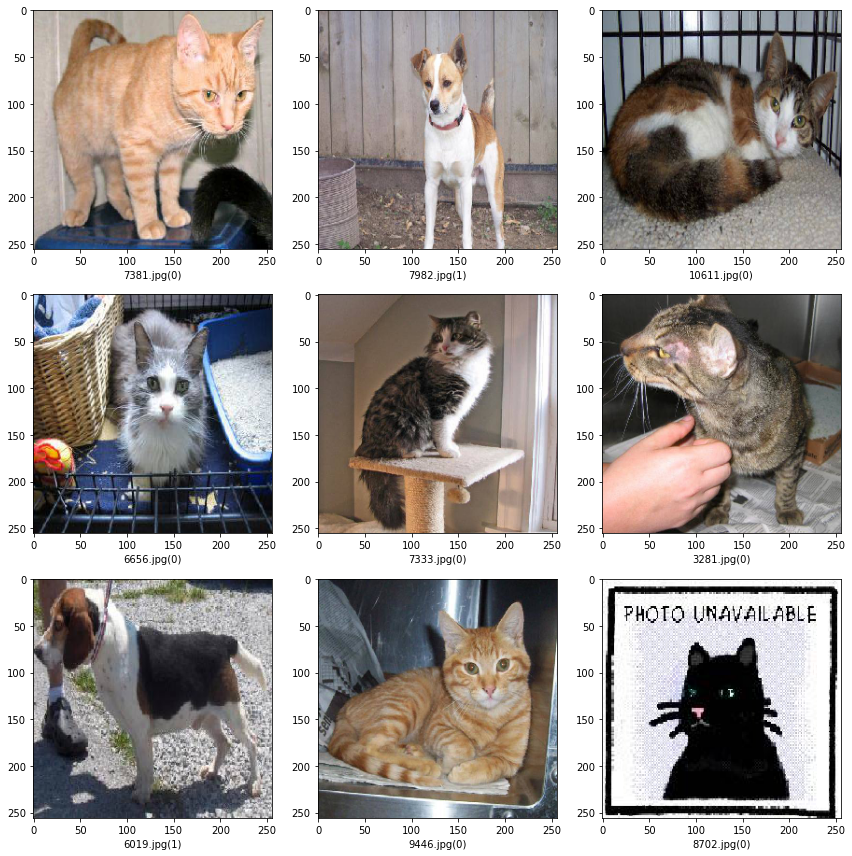

In [31]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, '(Test data)')

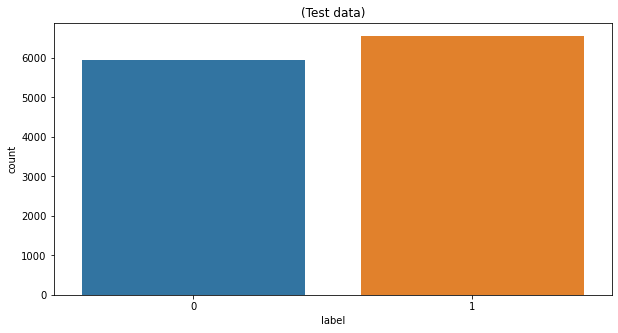

In [32]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")